In [1]:
!pip install -U gym gym[other] tensorflow keras autorom gym[accept-rom-license] gym[atari] torch

  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)


In [2]:
import numpy as np
from collections import deque
import gym
import random

In [3]:
env = gym.make("Pong-v4", obs_type='grayscale', render_mode='rgb_array', full_action_space=False)
env = gym.wrappers.AtariPreprocessing(env=env, frame_skip=1)
env = gym.wrappers.FrameStack(env=env, num_stack=4)
# env = gym.wrappers.RecordVideo(env, 'videos', episode_trigger= lambda x : x % 30 == 0)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In [4]:
env = gym.make("CartPole-v1")

In [5]:
state = env.reset()
state

(array([ 0.01973736, -0.04812356, -0.01754433,  0.03181923], dtype=float32),
 {})

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        """
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # Assuming input_shape is (channels, height, width)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the size of the output of the last conv layer
        def conv2d_size_out(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
        """
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        """
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        """
        return self.fc(x)

def update_target_network(target, source):
    target.load_state_dict(source.state_dict())


In [7]:
import copy
# Set parameters
N = 40000  # Replay memory capacity
M = 1000  # Number of episodes
T = 10000  # Max steps per episode
C = 40  # Target network update frequency
epsilon = 1
epsilon_decay = 0.99
epsilon_min = 0.1
gamma = 0.99
action_size = env.action_space.n  # Number of actions
state_size = env.observation_space.shape[0]  # State size

# Initialize replay memory


Q = DQN(action_size)
Q_hat = copy.deepcopy(Q)
D = deque(maxlen=N)


# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Q.to(device)
Q_hat.to(device)
optimizer = optim.Adam(Q.parameters(), lr=0.0025)
criterion = nn.MSELoss()



# Convert numpy array to PyTorch tensor
def preprocess_state(state):
  return torch.tensor(np.asarray(state)).float().div(255).unsqueeze(0).to(device)  # Scales to [0,1]

frames = 0
reward_list = []
loss_list = []

Using CPU


In [8]:
from tqdm import tqdm

# Training loop
for episode in tqdm(range(2000)):
    total_reward = 0
    state = preprocess_state(env.reset()[0])# Add batch dimension
    for t in range(T):
        # Epsilon-greedy action selection
        if np.random.rand() <= epsilon:
            action = random.randrange(action_size)
        else:
            with torch.no_grad():  # No need to track gradients here
                act_values = Q(state)
                action = act_values.max(1)[1].item()  # Choose the action with the highest Q-value

        # Execute action in environment and observe next state and reward
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        frames += 1

        next_state = preprocess_state(next_state)

        # Store transition in D (experience replay buffer)
        D.append((state, action, reward, next_state, done))
        d_len = len(D)

        state = next_state

        # Check if the episode is done
        if done :
            if episode % 20 == 0:
              print(f"Episode: {episode}/{M}, Score: {total_reward}, Nb_frames : {frames}")
            reward_list.append(total_reward)
            break



        # Train using a random minibatch from D
        if len(D) > 5000:
            minibatch = random.sample(D, 32)
            # Extract tensors from the minibatch
            states = torch.cat([s for s, a, r, ns, d in minibatch]).to(device)
            actions = torch.tensor([a for s, a, r, ns, d in minibatch], device=device).long()
            rewards = torch.tensor([r for s, a, r, ns, d in minibatch], device=device).float()
            next_states = torch.cat([ns for s, a, r, ns, d in minibatch]).to(device)
            dones = torch.tensor([d for s, a, r, ns, d in minibatch], device=device).float()


            # Compute Q values for current states
            Q_values = Q(states)
            # Select the Q value for the action taken, which are the ones we want to update
            Q_values = Q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            # Compute the Q values for next states using the target network
            with torch.no_grad():
                next_state_values = Q_hat(next_states).max(1)[0]
                # If done is true, we want to ignore the next state value
                next_state_values[dones == 1] = 0.0
                # Compute the target Q values
                target_Q_values = rewards + (gamma * next_state_values)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Compute loss
            loss = criterion(Q_values, target_Q_values)
            # Backward pass
            loss.backward()
            loss_list.append(loss.item())
            torch.nn.utils.clip_grad_norm_(Q.parameters(), max_norm=1.0)
            optimizer.step()

    # Update epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Update target network
    if episode % C == 0:
        Q_hat.load_state_dict(Q.state_dict())

  5%|▌         | 105/2000 [00:00<00:03, 528.22it/s]

Episode: 0/1000, Score: 15.0, Nb_frames : 15
Episode: 20/1000, Score: 12.0, Nb_frames : 438
Episode: 40/1000, Score: 11.0, Nb_frames : 791
Episode: 60/1000, Score: 16.0, Nb_frames : 1079
Episode: 80/1000, Score: 14.0, Nb_frames : 1368
Episode: 100/1000, Score: 9.0, Nb_frames : 1600


 11%|█         | 214/2000 [00:00<00:03, 499.05it/s]

Episode: 120/1000, Score: 10.0, Nb_frames : 1836
Episode: 140/1000, Score: 12.0, Nb_frames : 2069
Episode: 160/1000, Score: 10.0, Nb_frames : 2278
Episode: 180/1000, Score: 10.0, Nb_frames : 2478
Episode: 200/1000, Score: 12.0, Nb_frames : 2686


 13%|█▎        | 265/2000 [00:00<00:05, 336.24it/s]

Episode: 220/1000, Score: 10.0, Nb_frames : 2886
Episode: 240/1000, Score: 9.0, Nb_frames : 3079
Episode: 260/1000, Score: 8.0, Nb_frames : 3280


 17%|█▋        | 342/2000 [00:00<00:05, 327.09it/s]

Episode: 280/1000, Score: 10.0, Nb_frames : 3489
Episode: 300/1000, Score: 9.0, Nb_frames : 3682
Episode: 320/1000, Score: 9.0, Nb_frames : 3876
Episode: 340/1000, Score: 8.0, Nb_frames : 4075


 21%|██        | 412/2000 [00:01<00:05, 312.54it/s]

Episode: 360/1000, Score: 11.0, Nb_frames : 4275
Episode: 380/1000, Score: 8.0, Nb_frames : 4477
Episode: 400/1000, Score: 9.0, Nb_frames : 4676
Episode: 420/1000, Score: 10.0, Nb_frames : 4874
Episode: 440/1000, Score: 11.0, Nb_frames : 5088


 22%|██▏       | 445/2000 [00:01<00:14, 110.80it/s]

Episode: 460/1000, Score: 33.0, Nb_frames : 5373


 23%|██▎       | 469/2000 [00:03<00:29, 52.70it/s] 

Episode: 480/1000, Score: 11.0, Nb_frames : 5627


 25%|██▍       | 499/2000 [00:04<00:43, 34.18it/s]

Episode: 500/1000, Score: 11.0, Nb_frames : 5881


 26%|██▌       | 523/2000 [00:05<00:54, 27.03it/s]

Episode: 520/1000, Score: 9.0, Nb_frames : 6089


 27%|██▋       | 543/2000 [00:07<01:33, 15.51it/s]

Episode: 540/1000, Score: 22.0, Nb_frames : 6362


 28%|██▊       | 562/2000 [00:09<02:26,  9.84it/s]

Episode: 560/1000, Score: 8.0, Nb_frames : 6622


 29%|██▉       | 583/2000 [00:12<02:26,  9.65it/s]

Episode: 580/1000, Score: 19.0, Nb_frames : 7014


 30%|███       | 603/2000 [00:14<02:42,  8.60it/s]

Episode: 600/1000, Score: 9.0, Nb_frames : 7368


 31%|███       | 620/2000 [00:15<01:41, 13.59it/s]

Episode: 620/1000, Score: 8.0, Nb_frames : 7662


 32%|███▏      | 644/2000 [00:17<01:13, 18.34it/s]

Episode: 640/1000, Score: 42.0, Nb_frames : 8085


 33%|███▎      | 665/2000 [00:18<00:55, 24.04it/s]

Episode: 660/1000, Score: 34.0, Nb_frames : 8447


 34%|███▍      | 686/2000 [00:19<00:41, 31.92it/s]

Episode: 680/1000, Score: 10.0, Nb_frames : 8733


 35%|███▌      | 704/2000 [00:19<00:36, 35.21it/s]

Episode: 700/1000, Score: 10.0, Nb_frames : 8944


 36%|███▋      | 725/2000 [00:20<00:38, 33.44it/s]

Episode: 720/1000, Score: 29.0, Nb_frames : 9208


 37%|███▋      | 748/2000 [00:21<00:32, 38.47it/s]

Episode: 740/1000, Score: 10.0, Nb_frames : 9423


 38%|███▊      | 765/2000 [00:21<00:32, 37.78it/s]

Episode: 760/1000, Score: 8.0, Nb_frames : 9659


 39%|███▉      | 783/2000 [00:22<00:45, 26.60it/s]

Episode: 780/1000, Score: 15.0, Nb_frames : 9870


 40%|████      | 804/2000 [00:22<00:44, 26.64it/s]

Episode: 800/1000, Score: 10.0, Nb_frames : 10106


 41%|████      | 823/2000 [00:23<01:03, 18.67it/s]

Episode: 820/1000, Score: 9.0, Nb_frames : 10381


 42%|████▏     | 845/2000 [00:24<00:45, 25.21it/s]

Episode: 840/1000, Score: 19.0, Nb_frames : 10713


 43%|████▎     | 864/2000 [00:25<00:44, 25.42it/s]

Episode: 860/1000, Score: 10.0, Nb_frames : 11027


 44%|████▍     | 886/2000 [00:26<00:45, 24.45it/s]

Episode: 880/1000, Score: 9.0, Nb_frames : 11450


 45%|████▌     | 907/2000 [00:27<00:35, 30.43it/s]

Episode: 900/1000, Score: 12.0, Nb_frames : 11772


 46%|████▋     | 926/2000 [00:28<00:39, 27.15it/s]

Episode: 920/1000, Score: 16.0, Nb_frames : 12077


 47%|████▋     | 943/2000 [00:29<00:43, 24.26it/s]

Episode: 940/1000, Score: 16.0, Nb_frames : 12394


 48%|████▊     | 964/2000 [00:29<00:43, 23.66it/s]

Episode: 960/1000, Score: 9.0, Nb_frames : 12715


 49%|████▉     | 985/2000 [00:30<00:44, 22.70it/s]

Episode: 980/1000, Score: 10.0, Nb_frames : 13103


 50%|█████     | 1002/2000 [00:31<00:43, 23.11it/s]

Episode: 1000/1000, Score: 10.0, Nb_frames : 13435


 51%|█████     | 1022/2000 [00:32<00:37, 26.05it/s]

Episode: 1020/1000, Score: 14.0, Nb_frames : 13756


 52%|█████▏    | 1043/2000 [00:33<00:37, 25.59it/s]

Episode: 1040/1000, Score: 21.0, Nb_frames : 14071


 53%|█████▎    | 1063/2000 [00:33<00:36, 25.35it/s]

Episode: 1060/1000, Score: 9.0, Nb_frames : 14384


 54%|█████▍    | 1082/2000 [00:35<00:57, 16.10it/s]

Episode: 1080/1000, Score: 29.0, Nb_frames : 14787


 55%|█████▌    | 1104/2000 [00:36<00:55, 16.25it/s]

Episode: 1100/1000, Score: 9.0, Nb_frames : 15160


 56%|█████▌    | 1124/2000 [00:37<00:45, 19.08it/s]

Episode: 1120/1000, Score: 29.0, Nb_frames : 15474


 57%|█████▋    | 1145/2000 [00:38<00:35, 23.85it/s]

Episode: 1140/1000, Score: 10.0, Nb_frames : 15782


 58%|█████▊    | 1165/2000 [00:39<00:31, 26.65it/s]

Episode: 1160/1000, Score: 8.0, Nb_frames : 16083


 59%|█████▉    | 1184/2000 [00:39<00:39, 20.51it/s]

Episode: 1180/1000, Score: 24.0, Nb_frames : 16416


 60%|██████    | 1202/2000 [00:40<00:32, 24.32it/s]

Episode: 1200/1000, Score: 16.0, Nb_frames : 16699


 61%|██████    | 1224/2000 [00:41<00:38, 20.02it/s]

Episode: 1220/1000, Score: 31.0, Nb_frames : 17151


 62%|██████▏   | 1246/2000 [00:42<00:31, 23.87it/s]

Episode: 1240/1000, Score: 29.0, Nb_frames : 17512


 63%|██████▎   | 1264/2000 [00:44<00:52, 14.08it/s]

Episode: 1260/1000, Score: 44.0, Nb_frames : 18103


 64%|██████▍   | 1282/2000 [00:45<00:43, 16.64it/s]

Episode: 1280/1000, Score: 35.0, Nb_frames : 18566


 65%|██████▌   | 1301/2000 [00:47<01:04, 10.75it/s]

Episode: 1300/1000, Score: 45.0, Nb_frames : 19339


 66%|██████▌   | 1320/2000 [00:49<01:07, 10.01it/s]

Episode: 1320/1000, Score: 33.0, Nb_frames : 20049


 67%|██████▋   | 1342/2000 [00:52<01:19,  8.32it/s]

Episode: 1340/1000, Score: 24.0, Nb_frames : 20888


 68%|██████▊   | 1362/2000 [00:54<01:08,  9.36it/s]

Episode: 1360/1000, Score: 38.0, Nb_frames : 21769


 69%|██████▉   | 1381/2000 [00:57<01:26,  7.12it/s]

Episode: 1380/1000, Score: 47.0, Nb_frames : 22739


 70%|███████   | 1402/2000 [01:00<01:38,  6.09it/s]

Episode: 1400/1000, Score: 38.0, Nb_frames : 24141


 71%|███████   | 1421/2000 [01:04<01:40,  5.78it/s]

Episode: 1420/1000, Score: 59.0, Nb_frames : 25348


 72%|███████▏  | 1441/2000 [01:08<01:24,  6.62it/s]

Episode: 1440/1000, Score: 53.0, Nb_frames : 26913


 73%|███████▎  | 1461/2000 [01:12<01:41,  5.31it/s]

Episode: 1460/1000, Score: 61.0, Nb_frames : 28398


 74%|███████▍  | 1481/2000 [01:16<02:00,  4.30it/s]

Episode: 1480/1000, Score: 79.0, Nb_frames : 29804


 75%|███████▌  | 1501/2000 [01:21<02:02,  4.06it/s]

Episode: 1500/1000, Score: 102.0, Nb_frames : 31617


 76%|███████▌  | 1521/2000 [01:26<02:16,  3.51it/s]

Episode: 1520/1000, Score: 68.0, Nb_frames : 33727


 77%|███████▋  | 1541/2000 [01:32<02:09,  3.53it/s]

Episode: 1540/1000, Score: 176.0, Nb_frames : 35481


 78%|███████▊  | 1562/2000 [01:36<01:39,  4.41it/s]

Episode: 1560/1000, Score: 129.0, Nb_frames : 37168


 79%|███████▉  | 1581/2000 [01:45<02:33,  2.73it/s]

Episode: 1580/1000, Score: 169.0, Nb_frames : 39732


 80%|████████  | 1601/2000 [01:51<02:06,  3.15it/s]

Episode: 1600/1000, Score: 121.0, Nb_frames : 42170


 81%|████████  | 1621/2000 [01:58<01:54,  3.32it/s]

Episode: 1620/1000, Score: 88.0, Nb_frames : 44616


 82%|████████▏ | 1641/2000 [02:03<01:35,  3.76it/s]

Episode: 1640/1000, Score: 100.0, Nb_frames : 46644


 83%|████████▎ | 1661/2000 [02:11<02:05,  2.70it/s]

Episode: 1660/1000, Score: 143.0, Nb_frames : 49377


 84%|████████▍ | 1681/2000 [02:21<02:46,  1.91it/s]

Episode: 1680/1000, Score: 176.0, Nb_frames : 52626


 85%|████████▌ | 1701/2000 [02:29<01:43,  2.89it/s]

Episode: 1700/1000, Score: 130.0, Nb_frames : 55608


 86%|████████▌ | 1721/2000 [02:37<01:49,  2.56it/s]

Episode: 1720/1000, Score: 137.0, Nb_frames : 58637


 87%|████████▋ | 1741/2000 [02:47<02:13,  1.94it/s]

Episode: 1740/1000, Score: 178.0, Nb_frames : 61883


 88%|████████▊ | 1761/2000 [02:58<02:46,  1.43it/s]

Episode: 1760/1000, Score: 154.0, Nb_frames : 65599


 89%|████████▉ | 1781/2000 [03:10<02:09,  1.69it/s]

Episode: 1780/1000, Score: 165.0, Nb_frames : 69481


 90%|█████████ | 1801/2000 [03:20<01:33,  2.12it/s]

Episode: 1800/1000, Score: 170.0, Nb_frames : 73076


 91%|█████████ | 1821/2000 [03:31<01:25,  2.09it/s]

Episode: 1820/1000, Score: 135.0, Nb_frames : 76520


 92%|█████████▏| 1841/2000 [03:40<01:20,  1.98it/s]

Episode: 1840/1000, Score: 167.0, Nb_frames : 79614


 93%|█████████▎| 1861/2000 [03:52<01:15,  1.84it/s]

Episode: 1860/1000, Score: 161.0, Nb_frames : 83197


 94%|█████████▍| 1881/2000 [04:03<01:22,  1.44it/s]

Episode: 1880/1000, Score: 224.0, Nb_frames : 86658


 95%|█████████▌| 1901/2000 [04:13<00:52,  1.89it/s]

Episode: 1900/1000, Score: 148.0, Nb_frames : 90036


 96%|█████████▌| 1921/2000 [04:23<00:34,  2.32it/s]

Episode: 1920/1000, Score: 143.0, Nb_frames : 92992


 97%|█████████▋| 1941/2000 [04:32<00:24,  2.39it/s]

Episode: 1940/1000, Score: 142.0, Nb_frames : 95828


 98%|█████████▊| 1961/2000 [04:40<00:20,  1.87it/s]

Episode: 1960/1000, Score: 132.0, Nb_frames : 98488


 99%|█████████▉| 1979/2000 [04:48<00:08,  2.54it/s]

Episode: 1980/1000, Score: 18.0, Nb_frames : 100866


100%|██████████| 2000/2000 [04:55<00:00,  6.76it/s]


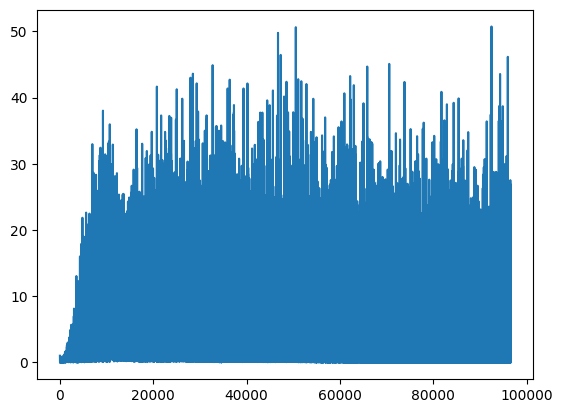

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

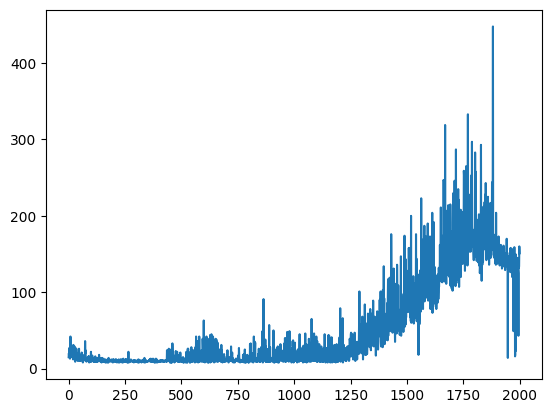

In [10]:
plt.plot(reward_list)

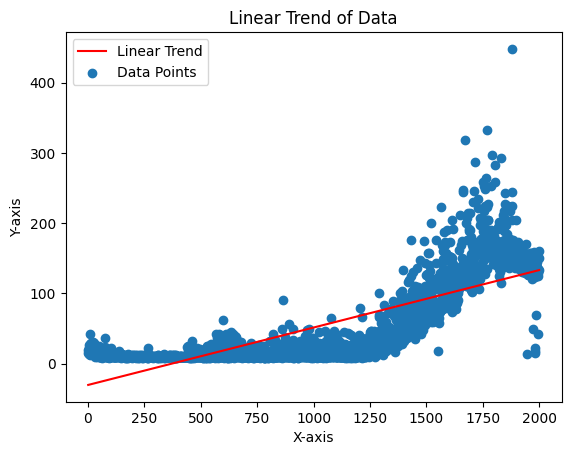

In [11]:
# Fit the linear model
x = np.arange(1, len(reward_list) + 1)
y = reward_list
coefficients = np.polyfit(x, y, 1)  # 1 means linear
polynomial = np.poly1d(coefficients)

# Generate a number of points for the x-axis (from min to max of your original x)
x_trend = np.linspace(x.min(), x.max(), 100)
# Predict the y values
y_trend = polynomial(x_trend)

# Plot the linear trend
plt.plot(x_trend, y_trend, label='Linear Trend', color='red')

# Optionally, if you want to plot the original data points:
plt.scatter(x, y, label='Data Points')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Trend of Data')
plt.legend()
plt.show()

In [12]:
state = preprocess_state(env.reset()[0])# Add batch dimension
total_reward = 0
q_values = []
while(True):
  with torch.no_grad():  # No need to track gradients here
    act_values = Q(state)
    action = act_values.max(1)[1].item()  # Choose the action with the highest Q-value
    q_values.append(act_values.to('cpu').numpy())
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    if done:
      break
    state = preprocess_state(next_state)
print(total_reward)

147.0
